In [1]:
import sys
from os import path 

scriptpath = ".."
sys.path.append(path.abspath(scriptpath))

from slp import Parser
import numpy as np
import pandas as pd

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import auc, accuracy_score, roc_curve, roc_auc_score, confusion_matrix, plot_roc_curve
from sklearn.utils import shuffle
from sklearn.model_selection import cross_validate, train_test_split, StratifiedKFold

import xgboost as xgb

from imblearn.over_sampling import RandomOverSampler

import matplotlib.pyplot as plt
import seaborn as sns
from collections import defaultdict

RANDOM = 1620 # Bacon's scientific method is born
np.random.seed(RANDOM)

In [2]:
with open('../data/nl2bash.cm') as f1:
    benign = f1.readlines()

with open('../data/malicious.cm') as f2:
    malicious = f2.readlines()

benign = [x.strip() for x in benign]
malicious = [x.strip() for x in malicious]

Xcm = benign + malicious
ycm = np.array([0] * len(benign) + [1] * len(malicious))

p = Parser(verbose=True)
X_counter, X_corpus = p.tokenize(Xcm)

[*] Parsing in process: 12730/12730


In [3]:
ros = RandomOverSampler(sampling_strategy='minority', random_state=RANDOM)

def encode_resample_shuffle(X_corpus, X_counter, y, ros, p, mode=None):
    X1 = p.encode(mode=mode, corpus=X_corpus, token_counter=X_counter, top_tokens=500, pad_width=500)
    #X2, yr = ros.fit_resample(X1, y)
    #return shuffle(X2, yr, random_state=RANDOM)
    return shuffle(X1, y, random_state=RANDOM)

X = {}
X["tfidf"], y = encode_resample_shuffle(X_corpus, X_counter, ycm, ros, p, mode="tf-idf")
X["one-hot"], _ = encode_resample_shuffle(X_corpus, X_counter, ycm, ros, p, mode="onehot")
X["labels"], _ = encode_resample_shuffle(X_corpus, X_counter, ycm, ros, p, mode="labels")

_ = [print(X[k].shape) for k in X]

[*] TF-IDF encoding: 12700/12730
(12730, 500)
(12730, 500)
(12730, 500)


In [4]:
xgb_model_mpg = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
xgb_model_mpg.fit(X["tfidf"], y)

y_pred = xgb_model_mpg.predict(X["tfidf"])
print(accuracy_score(y, y_pred))

0.9978004713275727


In [5]:
xgb_model_mpg.predict_proba(X["tfidf"])[::,1]

array([8.1740007e-05, 4.0951163e-05, 7.3648349e-05, ..., 2.1625407e-05,
       1.3330365e-04, 3.0851144e-05], dtype=float32)

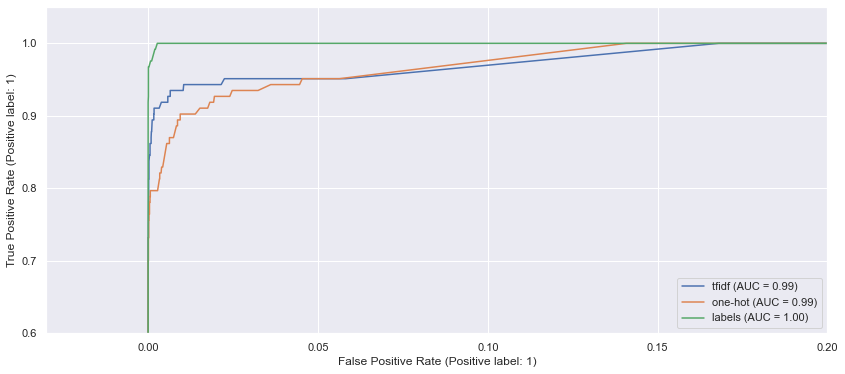

In [6]:
# Define a result table as a DataFrame
result_table = pd.DataFrame(columns=['encoding', 'fpr','tpr','auc'])

# Train the models and record the results
sns.set()
fig, ax = plt.subplots(figsize=(14,6))
for enc in X.keys():
    model = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")
    model.fit(X[enc], y)

    plot_roc_curve(model, X[enc], y, ax=ax, name=enc)

    yproba = model.predict_proba(X[enc])[::,1]
    fpr, tpr, _ = roc_curve(y,  yproba)
    aucvalue = roc_auc_score(y, yproba)
    
    result_table = result_table.append({'encoding': enc,
                                        'fpr':fpr, 
                                        'tpr':tpr, 
                                        'auc':aucvalue}, ignore_index=True)

ax.set_ylim(0.6,1.05)
ax.set_xlim(-0.03, 0.2)
# Set name of the classifiers as index labels
result_table.set_index('encoding', inplace=True)

In [7]:
result_table

,fpr,tpr,auc
encoding,,,
tfidf,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.008130081300813009, 0.0325203252032520...",0.994006
one-hot,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.008130081300813009, 0.0325203252032520...",0.993314
labels,"[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, ...","[0.0, 0.008130081300813009, 0.0731707317073170...",0.999948


# Cross-Validation

We just can't use sklearn's `train_test_split()` as is, because many malicious behavior commands have totally different pattern and purpose. Therefore, we need to find specific command subset, that characterize some family of malicious commands, and is in necessary amount to be present in both train and test sets.

Instead we will use cross validation, which gradually shifts training and test sets across all data corpus.

![image info](../img/cross_validation.png)

Code from:
https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc_crossval.html

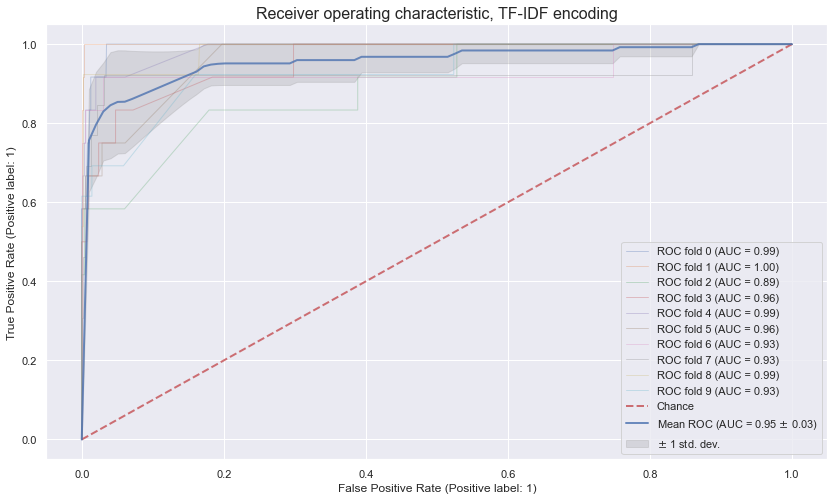

In [13]:
cv = StratifiedKFold(n_splits=10)

classifier = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
enc = "tfidf"

fig, ax = plt.subplots(figsize=(14,8))
for i, (train, test) in enumerate(cv.split(X[enc], y)):
    classifier.fit(X[enc][train], y[train])
    viz = plot_roc_curve(classifier, X[enc][test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title("Receiver operating characteristic, TF-IDF encoding", fontsize=16)
ax.legend(loc="lower right")

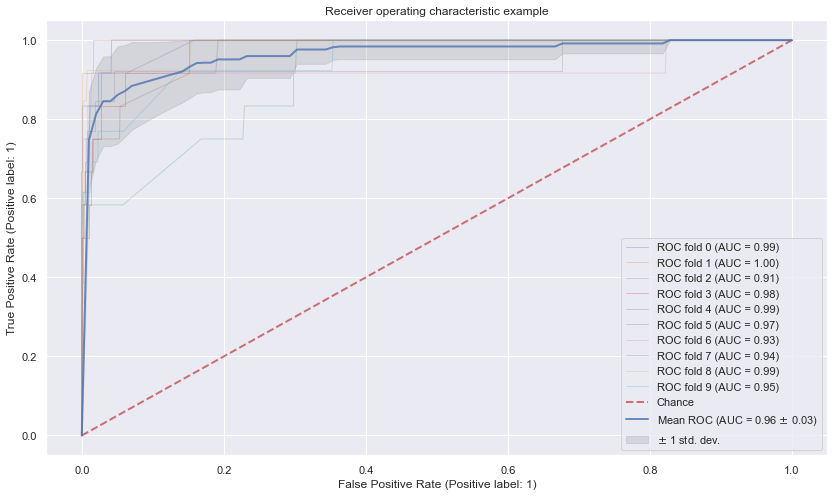

In [9]:
cv = StratifiedKFold(n_splits=10)

classifier = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
enc = "one-hot"

fig, ax = plt.subplots(figsize=(14,8))
for i, (train, test) in enumerate(cv.split(X[enc], y)):
    classifier.fit(X[enc][train], y[train])
    viz = plot_roc_curve(classifier, X[enc][test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")

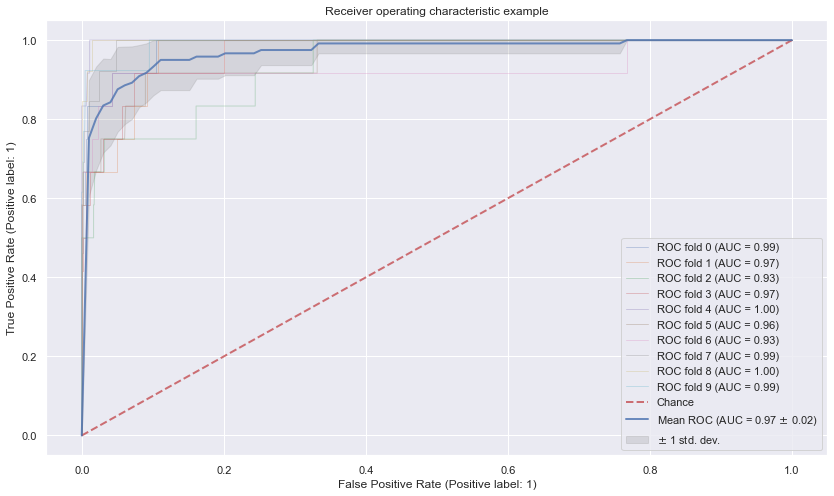

In [10]:
cv = StratifiedKFold(n_splits=10)

classifier = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")

tprs = []
aucs = []
mean_fpr = np.linspace(0, 1, 100)
enc = "labels"

fig, ax = plt.subplots(figsize=(14,8))
for i, (train, test) in enumerate(cv.split(X[enc], y)):
    classifier.fit(X[enc][train], y[train])
    viz = plot_roc_curve(classifier, X[enc][test], y[test],
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = np.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = np.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = np.std(tprs, axis=0)
tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example")
ax.legend(loc="lower right")

# All three ROC on the same plot with Cross-Validation (only mean, no folds)

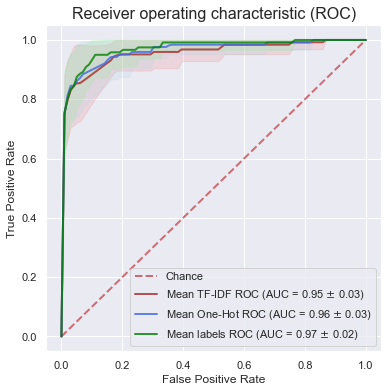

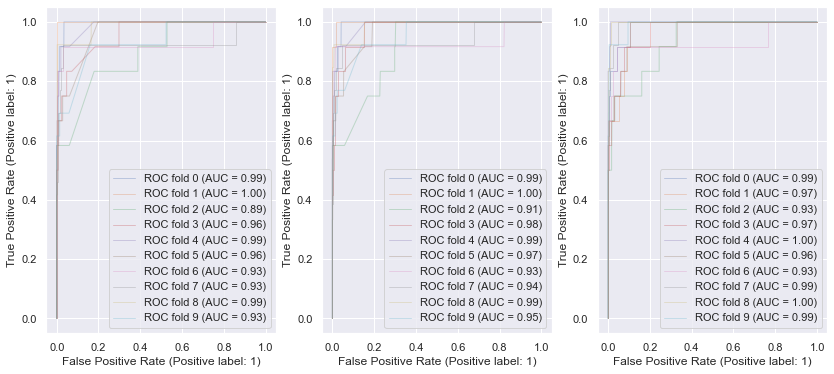

In [11]:
encs = ["tfidf", "one-hot", "labels"]
colors = {"tfidf": ["brown","lightcoral"], 
            "one-hot":["royalblue","lightblue"], 
            "labels":["green","lightgreen"]}

legend_vals = {}

cv = StratifiedKFold(n_splits=10)
fig, ax = plt.subplots(figsize=(6,6))
fig2,ax2 = plt.subplots(1,3, figsize=(14,6))

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05])
ax.set_title("Receiver operating characteristic (ROC)", fontsize=16)


for j,enc in enumerate(encs):
    classifier = xgb.XGBClassifier(n_estimators=100, use_label_encoder=False, eval_metric="logloss")

    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, 100)

    for i, (train, test) in enumerate(cv.split(X[enc], y)):
        classifier.fit(X[enc][train], y[train])
        viz = plot_roc_curve(classifier, X[enc][test], y[test],
                            name='ROC fold {}'.format(i),
                            alpha=0.3, lw=1, ax=ax2[j])
        
        interp_tpr = np.interp(mean_fpr, viz.fpr, viz.tpr)
        interp_tpr[0] = 0.0
        tprs.append(interp_tpr)
        aucs.append(viz.roc_auc)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=colors[enc][0],
            lw=2, alpha=.8)

    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=colors[enc][1], alpha=.2,
                    label=r'$\pm$ 1 std. dev.')
    legend_vals[enc] = [mean_auc, std_auc]

ax.legend(["Chance",
            f'Mean TF-IDF ROC (AUC = {legend_vals[encs[0]][0]:.2f} $\pm$ {legend_vals[encs[0]][1]:.2f})',
            f'Mean One-Hot ROC (AUC = {legend_vals[encs[1]][0]:.2f} $\pm$ {legend_vals[encs[1]][1]:.2f})' ,
            f'Mean labels ROC (AUC = {legend_vals[encs[2]][0]:.2f} $\pm$ {legend_vals[encs[2]][1]:.2f})'],
            loc="lower right")
ax.set_ylabel("True Positive Rate")
ax.set_xlabel("False Positive Rate")
fig.savefig("../img/roc_security_classification.png")